# 1A. Minkowski Functionals
___
**Author Contact:** <br>
Email: [bcchang@utexas.edu](mailto:bcchang@utexas.edu)

This notebook demonstrates some methods of computing the four Minkowski functionals (in 3D). The four Minkowski functionals are:

1. Volume
2. Surface Area
3. Integral Mean Curvature
4. Euler Characteristic

In this notebook, we compare Minkowski functional calculations via 2 methods: 
- Counts arrangements of $2^3$ neighborhoods of voxels using Quantimpy [[1]](#1) 
- Creates a mesh using Scikit-Image[[2]](#2), Trimesh, and Porespy[[4]](#4) 

______

## 0. Import some packages

In [4]:
# Some Utility functions
import os
import glob
import sys
sys.path.append('../')
# import src.utils

# Image processsing
import skimage
from skimage.morphology import ball

# Image visualization
import pyvista as pv
# pv.set_jupyter_backend('server')
import matplotlib.pyplot as plt
import tifffile

# Image quantification
import numpy as np
# from quantimpy import minkowski as mk
import porespy as ps
import trimesh



# Jupyter widgets
from ipywidgets import interact, interactive
import ipywidgets as widgets
from IPython.display import display, clear_output


In [5]:
def download_file_url(file_url,filename):

    # download file
    r = requests.get(file_url, stream = True) 

    with open(filename,"wb") as f: 
        for chunk in r.iter_content(chunk_size=1024): 

             # writing one chunk at a time to pdf file 
             if chunk: 
                 f.write(chunk)
    return()

In [ ]:
parent_dir = '../Data/'
file_names = ['gambier.ubc', 'beadpack.ubc', 'sandpack.ubc', 'castlegate.ubc']
file_dirs = [parent_dir+file for file in file_names]
file_links = ['https://www.digitalrocksportal.org/projects/16/origin_data/24/download',
              'https://www.digitalrocksportal.org/projects/16/origin_data/25/download',
              'https://www.digitalrocksportal.org/projects/16/origin_data/22/download',
              'https://www.digitalrocksportal.org/projects/16/origin_data/23/download']

for i in range(0,len(file_dirs)):
    download_file_url(file_links[i],file_dirs[i])

## 1. Computing the Minkowski Functionals<a class="anchor" id="chapter1"></a>

For the following introductory demonstrations, we will use a single solid sphere sample as the motivating example. At the end, we will have the opportunity to try the functions on the other samples.

Generally speaking, the Minkowski functionals can be computed using voxel methods or mesh methods. We will explore both here using the Quantimpy (voxelized) and the Trimesh/Skimage (mesh) libraries.

**In the following cell, we create and visualize a solid sphere of radius 100 voxels**


In [16]:
radius = 100
side_length = 250

sphere = np.zeros([side_length, side_length, side_length], dtype=np.uint8)
id_a = side_length // 2 - radius
id_b = side_length // 2 + radius + 1
sphere[id_a:id_b, id_a:id_b, id_a:id_b] = ball(radius, dtype=np.uint8)

plotter_obj = pv.Plotter(notebook=True, off_screen=False, lighting='three lights')

# Set background colors
plotter_obj.set_background(color='w')

# Set font colors and sizes
pv.global_theme.font.color = 'black'
pv.global_theme.font.size = 18
pv.global_theme.font.label_size = 14

pv.set_jupyter_backend('server')

pv_image_obj = pv.wrap(sphere)
contours = pv_image_obj.contour(isosurfaces=[0.5])
plotter_obj.add_mesh(contours, opacity=1, color=(200 / 255, 181 / 255, 152 / 255), diffuse=0.75, ambient=0.15)


plotter_obj.show(jupyter_backend='server')

Widget(value='<iframe src="http://localhost:53527/index.html?ui=P_0x31c862790_5&reconnect=auto" class="pyvista…

**Before we begin, we create a function to compare our package computations with the analytical solution**


In [17]:
def analytical_solution(radius):
    volume_analytical = 4/3 * np.pi * radius**3
    surface_area_analytical = 4 * np.pi * radius**2
    mean_curvature_analytical = 4 * np.pi * radius
    euler_analytical = 1.0
    
    return volume_analytical, surface_area_analytical, mean_curvature_analytical, euler_analytical


def compute_error(true, computed_measures):
    return [np.abs((true - compute) / true)*100 for compute in computed_measures]

volume_analytical, surface_area_analytical, mean_curvature_analytical, euler_analytical = analytical_solution(radius)


### 1.1 Volume Calculation

Considering a 3D body, $X$, with a smooth boundary, $\delta X$, the first Minkowski functional (volume) can be computed as:
$$ M_0(X) = \int_X dv $$

For a sphere, the volume can be found as:
$$ M_0 = \frac{4}{3} \pi R^3 $$

In practice, volume is the most straightforward of the Minkowski functionals set to compute.

Here, we compare a few different methods and packages for computing the volume of the pore space, split into voxelized methods and mesh methods:

1. Voxel Counting
2. Quantimpy (Voxelized)
3. Trimesh (Mesh)



In [18]:
def compute_volume(image):
    # Simple voxel counting
    voxel_counting = np.sum(image == 1)
    
    # Quantimpy
    quantimpy_measures = mk.functionals(image.astype(bool))[0]
    
    # Mesh Volume
    mesh_measures = np.abs(ps.metrics.mesh_volume(image))
    
    return voxel_counting, quantimpy_measures, mesh_measures

volume_measures = compute_volume(sphere)
volume_errors = compute_error(volume_analytical, volume_measures)

print("Volume Calculations:")
print(f"\tAnalytical Solution: {volume_analytical:0.3f}")
print(f"\tVoxel Counting: {volume_measures[0]:0.3f} \t Rel. Error: {volume_errors[0]:0.3f}%")
print(f"\tQuantimpy: {volume_measures[1]:0.3f} \t\t Rel. Error: {volume_errors[1]:0.3f}%")
print(f"\tMesh: {volume_measures[2]:0.3f} \t\t Rel. Error: {volume_errors[2]:0.3f}%")


Volume Calculations:
	Analytical Solution: 4188790.205
	Voxel Counting: 4187857.000 	 Rel. Error: 0.022%
	Quantimpy: 4187857.000 		 Rel. Error: 0.022%
	Mesh: 4187199.480 		 Rel. Error: 0.038%


### 1.2 Surface Calculation

The second Minkowski functional (surface area) can be computed as:
$$ M_1(X) = \int_{\delta X} ds $$

For a sphere, the surface area can be found as:
$$ M_1 = 4 \pi R^2 $$

Again, there are multiple ways to compute the surface area of the solid/pore boundary. Here, we compare:

1. Quantimpy (voxelized), and
2. Surface Mesh method (Skimage):

In [19]:
def compute_surface_area(image, smoothing=None):
    # Quantimpy
    quantimpy_surface_area = 8 * mk.functionals(image.astype(bool))[1]
    
    # Mesh Surface Area
    verts, faces, normals, values = skimage.measure.marching_cubes(image, level = smoothing)
    mesh_surface_area = skimage.measure.mesh_surface_area(verts, faces)
    
    return quantimpy_surface_area, mesh_surface_area

# Compute the surface area using 0.5 isosurface
surface_area_measures = compute_surface_area(sphere)
surface_area_errors = compute_error(surface_area_analytical, surface_area_measures)

# Compute the surface area using some other isosurface
_, surface_area_measures_blocky = compute_surface_area(sphere, smoothing:=0)
surface_area_errors_blocky = compute_error(surface_area_analytical, [surface_area_measures_blocky])

print("Surface Area Calculations:")
print(f"\tAnalytical Solution: {surface_area_analytical:0.3f}")
print(f"\tQuantimpy: {surface_area_measures[0]:0.3f} \t\t Rel. Error: {surface_area_errors[0]:0.3f}%")
print(f"\tMesh (0.5 Isosurface): {surface_area_measures[1]:0.3f} \t Rel. Error: {surface_area_errors[1]:0.3f}%")
print(f"\tMesh ({smoothing} Isosurface): {surface_area_measures_blocky:0.3f} \t Rel. Error: {surface_area_errors_blocky[0]:0.3f}%")

Surface Area Calculations:
	Analytical Solution: 125663.706
	Quantimpy: 125627.532 		 Rel. Error: 0.029%
	Mesh (0.5 Isosurface): 136694.734 	 Rel. Error: 8.778%
	Mesh (0 Isosurface): 137776.469 	 Rel. Error: 9.639%


### 1.3 Integral Mean Curvature Calculation

The third Minkowski functional (integral mean curvature area) can be computed as:
    $$ M_2(X) = \int_{\delta X} \frac{1}{2} \left[ \frac{1}{R_1} + \frac{1}{R_2} \right] ds $$
 
For a sphere, the principal radii of curvature are the same everywhere (i.e. $R_1 = R_2$). Therefore, the analytical integral mean curvature can be found as:
$$ M_2 = 4 \pi R $$

3D curvature measurements are not trivial to compute. Though there are many methods to compute the curvature, we will stick with the built in functions available in Quantimpy and the Trimesh library. 

1. Quantimpy (voxelized), and
2. Surface Mesh method (Implemented with Trimesh):

In [20]:
def compute_mean_curvature(image):
    # Quantimpy
    quantimpy_mean_curvature = 2*np.pi**2 * mk.functionals(image.astype(bool))[2]
    
    # Mesh Surface Area
    trimesh_sphere = trimesh.creation.icosphere(radius=radius)
    mesh_mean_curvature = trimesh_sphere.integral_mean_curvature
    
    return quantimpy_mean_curvature, mesh_mean_curvature

mean_curvature_measures = compute_mean_curvature(sphere)
mean_curvature_errors = compute_error(mean_curvature_analytical, mean_curvature_measures)

print("Mean Calculations:")
print(f"\tAnalytical Solution: {mean_curvature_analytical:0.3f}")
print(f"\tQuantimpy: {mean_curvature_measures[0]:0.3f} \t Rel. Error: {mean_curvature_errors[0]:0.3f}%")
print(f"\tMesh: {mean_curvature_measures[1]:0.3f} \t\t Rel. Error: {mean_curvature_errors[1]:0.3f}%")


Mean Calculations:
	Analytical Solution: 1256.637
	Quantimpy: 1259.275 	 Rel. Error: 0.210%
	Mesh: 1254.639 		 Rel. Error: 0.159%


### 1.4 Euler Characteristic

The fourth Minkowski functional (Gaussian curvature) can be computed as:
    $$ M_3(X) = \int_{\delta X} \left[ \frac{1}{R_1R_2} \right] ds $$

Because the principal radii of curvature are the same everywhere for a sphere (i.e. $R_1 = R_2$), the analytical total curvature can be found as:
$$ M_3 = 4 \pi$$
    
The Gauss-Bonnet theorem links the Gaussian Curvature to the Euler characteristic (or Euler number) by:

$$ 4\pi\chi = M_3(X)$$.

So, for a solid ball, the Euler number ($\chi$) $= 1$


Here, we compute the Euler number using:
1. Quantimpy, and
2. Skimage

In [21]:
def compute_euler_number(image):
    # Quantimpy
    quantimpy_euler_number = 4*np.pi/3 * mk.functionals(image.astype(bool))[3]
    
    # Mesh Surface Area
    skimage_euler_number = skimage.measure.euler_number(image, connectivity=3)
    
    return quantimpy_euler_number, skimage_euler_number

euler_number_measures = compute_euler_number(sphere)
euler_number_errors = compute_error(euler_analytical, euler_number_measures)

print("Euler Number Calculations:")
print(f"\tAnalytical Solution: {euler_analytical:0.3f}")
print(f"\tQuantimpy: {euler_number_measures[0]:0.3f} \t Rel. Error: {euler_number_errors[0]:0.3f}%")
print(f"\tSkimage: {euler_number_measures[1]:0.3f} \t\t Rel. Error: {euler_number_errors[1]:0.3f}%")


Euler Number Calculations:
	Analytical Solution: 1.000
	Quantimpy: 1.000 	 Rel. Error: 0.000%
	Skimage: 1.000 		 Rel. Error: 0.000%


## 2. Minkowski Functionals in Rock Samples

In the following cell, we compute the Minkowski functionals for the four samples we previously examined. For sake of simplicity, we will only use the Quantimpy library here.

### 2.1 Loading in our data

We load in TIFF images from the data directory. This directory contains segmented x-ray microtomography data from the Network Generation Comparison Forum and is available on the Digital Rocks Portal (https://www.digitalrocksportal.org/projects/16). 

For the purposes of this workshop, we have preprocessed the data to be in TIFF file format with solid and pore labeled as 0 and 1, respectively.

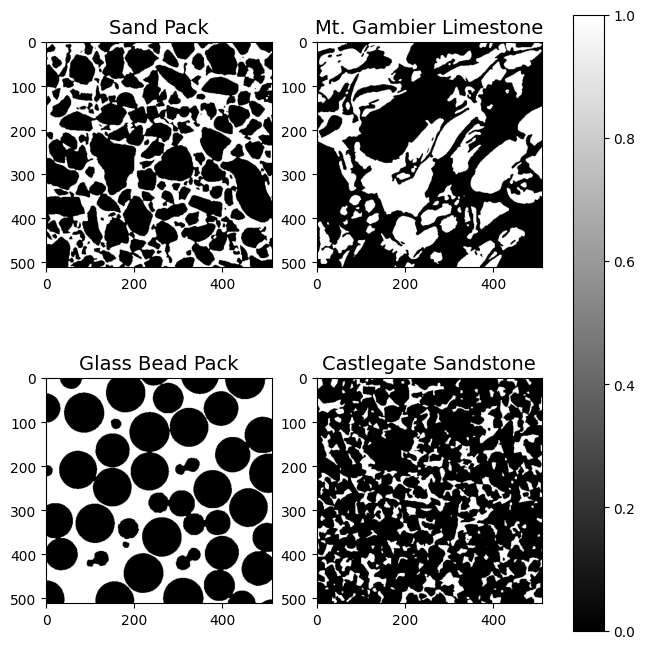

In [22]:
img_list = glob.glob('../data/*.tif')
gambier, beadpack, sandpack, castlegate = [tifffile.imread(tif_img) for tif_img in img_list]

fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(8,8))
ax = ax.flatten()

ax[0].imshow(sandpack[0,:,:], cmap='gray')
ax[0].set_title('Sand Pack',fontsize=14)

ax[1].imshow(gambier[0,:,:], cmap='gray')
ax[1].set_title('Mt. Gambier Limestone',fontsize=14)

ax[2].imshow(beadpack[0,:,:], cmap='gray')
ax[2].set_title('Glass Bead Pack',fontsize=14)

im = ax[3].imshow(castlegate[0,:,:], cmap='gray')
ax[3].set_title('Castlegate Sandstone',fontsize=14)

fig.colorbar(im, ax=ax.tolist())

plt.show()

### 2.2 3D Visualization

Here, we view our segmented image in 3D using the PyVista 3D visualization library.

<font color='red'>**Warning:**</font> These images are $512^3$ voxels and can be quite large to try to visualize on a local machine. By default, we plot a $100^3$ subset of the full images, but you can try to plot the entire image if your machine allows.

In [23]:
def plot_sample(sample, subset=True):
  
    plotter_obj = pv.Plotter(lighting='three lights')

    # Set background colors
    plotter_obj.set_background(color='w')

    # Set font colors and sizes
    pv.global_theme.font.color = 'black'
    pv.global_theme.font.size = 18
    pv.global_theme.font.label_size = 14
    
    pv.set_jupyter_backend('server')
    
    if subset:
        sample = sample[206:306, 206:306, 206:306]

    sample = np.pad(sample, ((1, 1), (1, 1), (1, 1)), mode='constant', constant_values=1)
    
    pv_image_obj = pv.wrap(sample)
    contours = pv_image_obj.contour(isosurfaces=[0.5])
    plotter_obj.add_mesh(contours, opacity=1, color=(200 / 255, 181 / 255, 152 / 255), diffuse=0.75, ambient=0.15)
    
    
    plotter_obj.show(jupyter_backend='server')

    

#### 2.2.1 3D Plot of Beadpack

In [25]:
# 100^3 subsample
# plot_sample(beadpack, subset=True)

# Uncomment for Full 512^3 sample
plot_sample(beadpack, subset=False)

Widget(value='<iframe src="http://localhost:53527/index.html?ui=P_0x321a88a10_7&reconnect=auto" class="pyvista…

#### 2.2.2 3D Plot of Sandpack

In [27]:
# 100^3 subsample
# plot_sample(sandpack, subset=True)

# Uncomment for Full 512^3 sample
plot_sample(sandpack, subset=False)

Widget(value='<iframe src="http://localhost:53527/index.html?ui=P_0x32c8aced0_9&reconnect=auto" class="pyvista…

#### 2.2.3 3D Plot of Castlegate Sandstone

In [28]:
# 100^3 subsample
plot_sample(castlegate, subset=True)

# Uncomment for Full 512^3 sample
# plot_sample(castlegate, subset=False)

Widget(value='<iframe src="http://localhost:53527/index.html?ui=P_0x32c8af090_10&reconnect=auto" class="pyvist…

#### 2.2.4 3D Plot of Mt. Gambier Limestone

In [29]:
# 100^3 subsample
plot_sample(gambier, subset=True)

# Uncomment for Full 512^3 sample
# plot_sample(gambier, subset=False)

Widget(value='<iframe src="http://localhost:53527/index.html?ui=P_0x302960b10_11&reconnect=auto" class="pyvist…

In [30]:
def get_quantimpy_mf(image):
    mf0, mf1, mf2, mf3 = mk.functionals(image.astype(bool))
    mf1 *= 8
    mf2 *= 2*np.pi**2
    mf3 *= 4*np.pi/3
    return [mf0, mf1, mf2, mf3]

def compute_sample_mf(sample):
    
    sample_dict = {'Sandpack': sandpack,
                  'Mt. Gambier Limestone': gambier, 
                   'Beadpack': beadpack, 
                   'Castlegate Sandstone': castlegate}
    
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
    
    plt.imshow(sample_dict[sample][0], cmap='gray')
    ax.set_title(sample,fontsize=14)
    plt.colorbar()
    mfs = get_quantimpy_mf(sample_dict[sample])

    print('Minkowski Functionals:')
    print(f'\tVolume: {mfs[0]:0.3f}')
    print(f'\tSurface Area: {mfs[1]:0.3f}')
    print(f'\tIntegral Mean Curvature: {mfs[2]:0.3f}')
    print(f'\tEuler Number: {mfs[3]:0.3f}')
    
interactive(compute_sample_mf, sample=widgets.Dropdown(options=['Beadpack', 'Sandpack', 'Mt. Gambier Limestone', 'Castlegate Sandstone'],
                                                description='Sample: ',
                                                value='Beadpack'),)

    


interactive(children=(Dropdown(description='Sample: ', options=('Beadpack', 'Sandpack', 'Mt. Gambier Limestone…

## References
<a id="1">[1]</a> 
Boelens, A. M. P. and Tchelepi, H. A. (2021). 
QuantImPy: Minkowski functionals and functions with Python.
SoftwareX, Volume 16, doi: [10.1016/j.softx.2021.100823](https://www.sciencegate.app/app/redirect#aHR0cHM6Ly9keC5kb2kub3JnLzEwLjEwMTYvai5zb2Z0eC4yMDIxLjEwMDgyMw==)


<a id="2">[2]</a> 
Van der Walt, S. et al. (2014). 
scikit-image: image processing in Python.  PeerJ, 2, p.e453.


<a id="3">[3]</a> 
Gostick, J. et al. (2019). 
PoreSpy: A Python Toolkit for Quantitative Analysis of Porous Media Images. Journal of Open Source Software, [doi:10.21105/joss.01296](https://doi.org/10.21105/joss.01296)